In [ ]:
!pip install -q --force transformers==4.52.4
!pip install -U bitsandbytes
!pip install -q --force accelerate==1.7.0
!pip install -q --force langchain==0.3.25
!pip install -q --force langchainhub==0.1.21
!pip install -q --force langchain-chroma==0.2.4
!pip install -q --force langchain_experimental==0.3.4
!pip install -q --force langchain-community==0.3.24
!pip install -q --force langchain_huggingface==0.2.0
!pip install -q --force python-dotenv==1.1.0
!pip install -q --force pypdf
!pip install langchain_openai
!pip install langchain-google-genai
!pip install rank_bm25


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
contourpy 1.2.0 requires numpy<2.0,>=1.20, but you have numpy 2.3.4 which is incompatible.
datasets 3.6.0 requires fsspec[http]<=2025.3.0,>=2023.1.0, but you have fsspec 2025.10.0 which is incompatible.
gensim 4.3.3 requires numpy<2.0,>=1.18.5, but you have numpy 2.3.4 which is incompatible.
numba 0.60.0 requires numpy<2.1,>=1.22, but you have numpy 2.3.4 which is incompatible.
s3fs 2024.6.1 requires fsspec==2024.6.1.*, but you have fsspec 2025.10.0 which is incompatible.
scipy 1.13.1 requires numpy<2.3,>=1.22.4, but you have numpy 2.3.4 which is incompatible.
streamlit 1.37.1 requires packaging<25,>=20, but you have packaging 25.0 which is incompatible.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependenc

In [1]:
import torch
print(torch.__version__ )
print(torch.cuda.is_available())


2.8.0+cu126
True


In [1]:
from dotenv import load_dotenv
import os

# Load environment variables from .env in project root
load_dotenv()

googleAPIKey = os.getenv('googleAPIKey')
gptkey =  os.getenv('myAPIKey')

os.environ["GOOGLE_API_KEY"] = googleAPIKey

In [2]:
from transformers import BitsAndBytesConfig, AutoModelForCausalLM, AutoModelForSequenceClassification,AutoTokenizer, pipeline
from langchain_huggingface import HuggingFacePipeline
from langchain_huggingface import HuggingFaceEmbeddings
from langchain import hub

from langchain_experimental.text_splitter import SemanticChunker
from langchain_openai import OpenAIEmbeddings
import re

import torch
import json
import glob
import os


c:\Users\ADMIN\anaconda3\envs\Phuc1\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Load file

In [2]:
metadata_dir = "C:\\uit_HK5\\CS431\\final_project\\data\\metadata.json"
transcript_dir = "C:\\uit_HK5\\CS431\\final_project\\data\\transcripts_final"
output_dir = "C:\\uit_HK5\\CS431\\final_project\\data\\semantic_chunks"
os.makedirs(output_dir, exist_ok=True)


In [3]:
from typing import Union

class Loader:
    @staticmethod
    def parse_transcript(file_path: str) -> tuple[str, list[dict], str]:
        """Đọc file transcript, tách từng dòng thành block có start-end-text"""
        full_text = ""
        position_map = []  # lưu vị trí start của mỗi đoạn text trong full_text

        with open(file_path, "r", encoding="utf-8") as f:
            for line in f:
                line = line.strip()
                if not line or "[âm nhạc]" in line.lower():
                    continue
                filename = os.path.basename(file_path).replace(".txt", "") # lấy file name
                match = re.match(r"(\d+:\d+:\d+)\s*-\s*(\d+:\d+:\d+),\s*(.+)", line)
                if match:
                    start, end, text = match.groups()
                    pos = len(full_text)
                    full_text += text + " "
                    position_map.append({
                        "start": start,
                        "end": end,
                        "text": text,
                        "pos_start": pos, # vị trí bắt đầu của đoạn text trong full_text
                        "pos_end": len(full_text) # vị trí kết thúc của đoạn text trong full_text
                    })

        return full_text.strip(), position_map, filename
    
    def map_metadata(self, metadata_path: str, filename: str) -> tuple[Union[str, None], Union[str, None]]:
        """Đọc file metadata và trả về dict mapping id -> metadata"""

        with open(metadata_path, "r", encoding="utf-8") as f:
            metadata_list = json.load(f)
        metadata = metadata_list["videos"]

        video_title, video_url = next(((item["title"], item["url"]) for item in metadata if item["video_id"] == filename), (None, None))

        return video_title, video_url
    
    def load_dir(self, transcript_dir: str, metadata_path: str) -> list[dict]:
        """Đọc tất cả file transcript trong thư mục và trả về danh sách dict chứa full_text, position_map, filename, title, url"""
        import glob

        file_paths = glob.glob(os.path.join(transcript_dir, "*.txt"))
        data = []

        for file_path in file_paths:
            full_text, position_map, filename = self.parse_transcript(file_path)
            title, url = self.map_metadata(metadata_path, filename)

            data.append({
                "full_text": full_text,
                "position_map": position_map,
                "filename": filename,
                "title": title,
                "url": url
            })

        return data
        

## Chunking

## Semantic

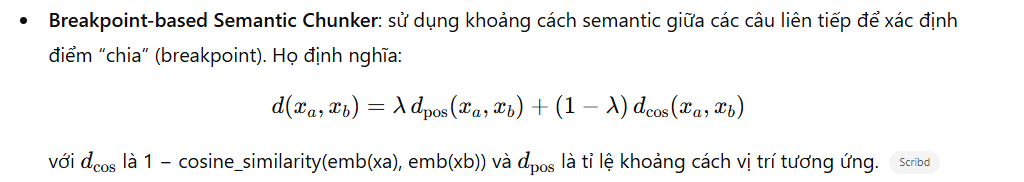

In [2]:

from pyparsing import line


class TranscriptChunker:
    def __init__(self, open_api_key: str):
        self.embeddings = OpenAIEmbeddings(
            model="text-embedding-3-large",
            openai_api_key=open_api_key
        )
        self.splitter = SemanticChunker(
            embeddings=self.embeddings,
            breakpoint_threshold_type="percentile",
            breakpoint_threshold_amount=85,
            min_chunk_size=300,

            add_start_index=True,
            buffer_size=1
        )
        self.loader = Loader()

    def chunk_dir(self, transcript_dir: str, metadata_path: str, output_dir: str) -> list:
        data = self.loader.load_dir(transcript_dir, metadata_path)
        all_chunks = []

        for item in data:
            full_text = item["full_text"]
            position_map = item["position_map"]
            filename = item["filename"]
            title = item["title"]
            url = item["url"]

            # dùng lại logic mapping timestamp
            chunks = self.splitter.create_documents(
                texts=[full_text],
                metadatas=[{
                    "video_url": url,
                    "filename": filename,
                    "title": title
                }]
            )
            for i, chunk in enumerate(chunks):
                start_index = chunk.metadata.pop("start_index")
                end_index = start_index + len(chunk.page_content)  # tự tính end_index

                
                # tìm timestamp đầu tiên bao phủ đoạn text này
                matched_ts = [
                    pos for pos in position_map
                    if not (pos["pos_end"] < start_index or pos["pos_start"] > end_index)
                ]

                if matched_ts:
                    chunk.metadata["start_timestamp"] = matched_ts[0]["start"]
                    chunk.metadata["end_timestamp"] = matched_ts[-1]["end"]
                else:
                    chunk.metadata["start_timestamp"] = None
                    chunk.metadata["end_timestamp"] = None

                chunk.metadata["chunk_id"] = i
            all_chunks.extend(chunks)
        # lưu tất cả chunks vào file json
        output_path = os.path.join(output_dir, "semantic_chunks.json")
        with open(output_path, "w", encoding="utf-8") as f:
            json.dump([{
                "page_content": chunk.page_content,
                "metadata": chunk.metadata
            } for chunk in all_chunks], f, ensure_ascii=False, indent=4)
        print(f"Saved {len(all_chunks)} chunks to {output_path}")
        return all_chunks


In [11]:
splitter = TranscriptChunker(
    open_api_key= gptkey
)
data = splitter.chunk_dir(transcript_dir, metadata_dir, output_dir)

Saved 461 chunks to C:\uit_HK5\CS431\final_project\data\semantic_chunks\semantic_chunks.json


In [12]:
#test print first 3 chunks
for chunk in data[:3]:
    print(chunk.page_content)
    print(chunk.metadata["start_timestamp"], chunk.metadata["end_timestamp"])
    print(chunk.metadata["video_url"])
    print(chunk.metadata["title"])
    print("-----")

Như vậy thì trong phần số 2 này thì chúng ta đã cùng tìm hiểu về những chủ đề sau. Đầu tiên là chúng ta tìm hiểu về maximum likelihood cho cái log của PX. Chúng ta mong muốn có được một mô hình để tạo ra một cái ảnh x giống thật, giống với lại cái Pdata. Thế thì để đạt được cái việc này thì cái likelihood của log P này phải là lớn nhất. Và khi đưa cái log của PX này lên cực đại thì nó sẽ đưa đến một cái giải pháp, đó là chúng ta sẽ đẩy cái chặn dưới của log P. Thì đó chính là cái ELBO là evidence lower bound.
0:00:14 0:01:06
https://youtube.com/watch?v=--6FInuIyys
[CS315 - Chương 3] Deep Generative Models (2) - Tổng kết
-----
Đẩy cái ELBO này lên, maximum ELBO này lên. Và khi chúng ta maximum ELBO này lên thì chúng ta sẽ có hai cái mô hình, đó là VAE và mô hình diffusion. Và đối với cái mô hình diffusion thì chúng ta sẽ có cái bước gọi là khuếch tán thuận. Và trong cái khuếch tán thuận này thì chúng ta sẽ thêm nhiễu vào cái ảnh của mình. Và ở đây là chúng ta không có tham số để học, kh

## recursive

In [83]:
import os
import json
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.embeddings import OpenAIEmbeddings
from langchain.schema import Document

class TranscriptChunker:
    def __init__(self):
        # Recursive chunker
        self.splitter = RecursiveCharacterTextSplitter(
            chunk_size=500,        # kích thước chunk tối đa
            chunk_overlap=50       # overlap giữa các chunk
        )
        self.loader = Loader()  # giả sử bạn đã định nghĩa Loader

    def chunk_dir(self, transcript_dir: str, metadata_path: str, output_dir: str) -> list:
        data = self.loader.load_dir(transcript_dir, metadata_path)
        all_chunks = []

        for item in data:
            full_text = item["full_text"]
            position_map = item["position_map"]
            filename = item["filename"]
            title = item["title"]
            url = item["url"]

            # chia chunk bằng recursive splitter
            text_chunks = self.splitter.split_text(full_text)

            chunks = []
            start_idx = 0
            for i, chunk_text in enumerate(text_chunks):
                end_idx = start_idx + len(chunk_text)

                # tìm timestamp đầu tiên bao phủ đoạn text này
                matched_ts = [
                    pos for pos in position_map
                    if not (pos["pos_end"] < start_idx or pos["pos_start"] > end_idx)
                ]

                metadata = {
                    "video_url": url,
                    "filename": filename,
                    "title": title,
                    "chunk_id": i,
                    "start_timestamp": matched_ts[0]["start"] if matched_ts else None,
                    "end_timestamp": matched_ts[-1]["end"] if matched_ts else None
                }

                chunks.append(Document(page_content=chunk_text, metadata=metadata))
                start_idx = end_idx

            all_chunks.extend(chunks)

        # lưu tất cả chunks vào file json
        output_path = os.path.join(output_dir, "recursive_chunks.json")
        with open(output_path, "w", encoding="utf-8") as f:
            json.dump([{
                "page_content": chunk.page_content,
                "metadata": chunk.metadata
            } for chunk in all_chunks], f, ensure_ascii=False, indent=4)

        print(f"Saved {len(all_chunks)} chunks to {output_path}")
        return all_chunks


In [84]:
splitter = TranscriptChunker()
data = splitter.chunk_dir(transcript_dir, metadata_dir, output_dir)

Saved 1476 chunks to C:\uit_HK5\CS431\final_project\data\semantic_chunks\recursive_chunks.json


## lưu db recursive

In [86]:
from langchain_community.vectorstores import Chroma
from langchain_huggingface import HuggingFaceEmbeddings


model_name = "BAAI/bge-m3"            # đa ngôn ngữ, gọn nhẹ, khuyên dùng

embedding = HuggingFaceEmbeddings(model_name=model_name,model_kwargs={"device": "cuda"})

## lưu vào db
vector_db = Chroma.from_documents(documents=data, embedding=embedding, persist_directory="../database_recursive")
vector_retriever = vector_db.as_retriever( search_type="mmr", search_kwargs={"k": 40, "fetch_k": 80, "lambda_mult": 0.3})

In [16]:
from sklearn.manifold import TSNE
import plotly.graph_objects as go
import numpy as np

# 🔹 Lấy toàn bộ embedding và metadata từ Chroma
# (nếu bạn đã load vector_db = Chroma.from_documents(...) như trên)
data = vector_db.get()  

vectors = vector_db.get(include=["embeddings"])
vectors = np.array(vectors["embeddings"])
documents = data["documents"]
metadatas = data["metadatas"]

# 🔹 Nếu bạn có nhiều loại document, có thể trích ra từ metadata
doc_types = [m.get("title", "unknown") for m in metadatas]
colors = ["blue" if t == "unknown" else "red" for t in doc_types]

# 🔹 Giảm số chiều xuống 2D để trực quan hóa
tsne = TSNE(n_components=2, random_state=42, perplexity=1)
reduced_vectors = tsne.fit_transform(vectors)

# 🔹 Vẽ biểu đồ scatter 2D
fig = go.Figure(data=[go.Scatter(
    x=reduced_vectors[:, 0],
    y=reduced_vectors[:, 1],
    mode='markers',
    marker=dict(size=6, color=colors, opacity=0.8),
    text=[
        f"<b>Loại:</b> {t}<br><b>Văn bản:</b> {d[:200]}..." 
        for t, d in zip(doc_types, documents)
    ],
    hoverinfo='text'
)])

fig.update_layout(
    title='📊 Phân bố embedding trong Chroma Vector Store (2D)',
    xaxis_title='TSNE Dimension 1',
    yaxis_title='TSNE Dimension 2',
    width=900,
    height=700,
    margin=dict(r=20, b=10, l=10, t=40),
)

# 🔹 Hiển thị trực tiếp trên browser
fig.show(renderer="browser")


## Reranking by crossencoder + create hybrid search with semantic search + bm25

## Load db + vector retriever


In [3]:
from langchain_community.vectorstores import Chroma
from langchain_huggingface import HuggingFaceEmbeddings


model_name = "BAAI/bge-m3"            # đa ngôn ngữ, gọn nhẹ, khuyên dùng

embedding = HuggingFaceEmbeddings(model_name=model_name,model_kwargs={"device": "cpu"})

## lưu vào db
vector_db = Chroma( embedding_function= embedding, persist_directory="../database")
vector_retriever = vector_db.as_retriever( search_type="mmr", search_kwargs={"k": 40, "fetch_k": 80, "lambda_mult": 0.3})

C:\Users\ADMIN\AppData\Local\Temp\ipykernel_38344\3508899957.py:10: LangChainDeprecationWarning: The class `Chroma` was deprecated in LangChain 0.2.9 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-chroma package and should be used instead. To use it run `pip install -U :class:`~langchain-chroma` and import as `from :class:`~langchain_chroma import Chroma``.
  vector_db = Chroma( embedding_function= embedding, persist_directory="../database")


In [9]:
import time
start= time.time()
response = vector_retriever.get_relevant_documents("diffusion là gì")
end = time.time()
print(f"Time taken: {end - start} seconds")


Time taken: 0.16023540496826172 seconds


## Reranker

In [4]:
import torch
from typing import List
from transformers import AutoTokenizer, AutoModelForSequenceClassification

from langchain_huggingface import HuggingFaceEmbeddings

rerank_model_name = "BAAI/bge-reranker-base"
tok = AutoTokenizer.from_pretrained(rerank_model_name)
reranker = AutoModelForSequenceClassification.from_pretrained(rerank_model_name)
reranker.to(device="cuda" if torch.cuda.is_available() else "cpu")
reranker.eval()


XLMRobertaForSequenceClassification(
  (roberta): XLMRobertaModel(
    (embeddings): XLMRobertaEmbeddings(
      (word_embeddings): Embedding(250002, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): XLMRobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x XLMRobertaLayer(
          (attention): XLMRobertaAttention(
            (self): XLMRobertaSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): XLMRobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=

In [5]:
@torch.no_grad()
def batch_crossencoder_scores(q: str, texts: List[str], batch_size: int = 64, max_len: int = 512) -> List[float]:
    scores = []
    for i in range(0, len(texts), batch_size):
        batch = texts[i : i + batch_size]
        inputs = tok([q]*len(batch), batch, padding=True, truncation=True, max_length=max_len, return_tensors="pt")
        inputs = {k: v.to(device="cuda" if torch.cuda.is_available() else "cpu") for k, v in inputs.items()} # chuyển lên gpu
        logits = reranker(**inputs).logits.squeeze(-1)
        scores.extend(logits.tolist())
    return scores


def crossencoder_rerank(docs, query: str, top_k: int = 10):
    texts = [d.page_content for d in docs]
    scores = batch_crossencoder_scores(query, texts, batch_size=16, max_len=512)
    ranked = sorted(zip(docs, scores), key=lambda x: x[1], reverse=True)

    BAD_HINTS = ("Cảm ơn các bạn đã xem", "đăng ký kênh", "subscribe", "like và share")
    final_docs = []
    for d, s in ranked:
        if all(h.lower() not in d.page_content.lower() for h in BAD_HINTS):
            final_docs.append(d)
        if len(final_docs) >= top_k:
            break
    return final_docs

In [6]:
import time
## test reranker
start= time.time()
query = "diffusion là gì"
docs = vector_retriever.get_relevant_documents(query)
reranked_docs = crossencoder_rerank(docs, query, top_k=10)
end = time.time()
print(f"Reranking Time taken: {end - start} seconds")

for i, d in enumerate(reranked_docs):
    m = d.metadata
    print(f"[{i}]  | {m.get('title', '')} | {m.get('video_url', '')}")
    print(f"    {m.get('start_timestamp', '?')} → {m.get('end_timestamp', '?')}")
    text = d.page_content.replace("\n", " ").strip()
    print("   " + (text[:300] + ("..." if len(text) > 300 else "")))
    print("-" * 80)


C:\Users\ADMIN\AppData\Local\Temp\ipykernel_38344\3792054541.py:5: LangChainDeprecationWarning: The method `BaseRetriever.get_relevant_documents` was deprecated in langchain-core 0.1.46 and will be removed in 1.0. Use :meth:`~invoke` instead.
  docs = vector_retriever.get_relevant_documents(query)


Reranking Time taken: 1.1450636386871338 seconds
[0]  | [CS315 - Chương 3] Deep Generative Models (2) - Part 1 | https://youtube.com/watch?v=SCNZncN1Hvk
    0:00:14 → 0:01:11
   Chúng ta sẽ cùng đến với các mô hình tạo sinh học sau Deep Generated Model phần 2, mô hình Diffusion. Các mô hình tạo sinh hình ảnh đều có gốc gác sử dụng mô hình phát tán, mô hình Diffusion Model. Đây có thể nói là một trong những mô hình có tính ứng dụng rất cao do tạo ra những ảnh có độ phân giải...
--------------------------------------------------------------------------------
[1]  | [CS315 - Chương 0] Giới thiệu môn học (Phần 1) | https://youtube.com/watch?v=RU8d6QAuX0k
    0:04:07 → 0:05:48
   Đó chính là mô hình dựa trên xác suất và cụ thể của một mô hình dựa trên xác suất đó chính là mô hình khuếch tán là Diffusion Model. Sau đó sang tuần thứ 11 thì chúng ta sẽ cùng tìm hiểu về những mô hình học sâu nhưng mà có sự tham gia của ngôn ngữ và thị giác hay còn gọi là Vision Language Model. Đ...
------------

## bm25

In [7]:
from langchain.schema import Document
from langchain_community.retrievers import BM25Retriever
from langchain.retrievers import EnsembleRetriever

# ===== 1. Load docs từ Chroma =====
raw = vector_db.get(include=["documents", "metadatas"])
docs = []

for content, metadata in zip(raw["documents"], raw["metadatas"]):
    docs.append(Document(
        page_content=content,
        metadata={
            "filename": metadata.get("filename", ""),
            "video_url": metadata.get("video_url", ""),
            "start_timestamp": metadata.get("start_timestamp", "")
        }
    ))

# ===== 2. BM25 retriever từ LangChain =====
if docs:
    bm25_retriever = BM25Retriever.from_documents(docs)
    bm25_retriever.k = 30     # số lượng trả về
else:
    bm25_retriever = None

## Hybrid : semantic search + keyword search

In [13]:

# ===== 3. Hybrid retriever =====
if bm25_retriever is None:
    hybrid_retriever = EnsembleRetriever(
        retrievers=[vector_retriever],
        weights=[1]
    )
else:
    hybrid_retriever = EnsembleRetriever(
        retrievers=[bm25_retriever, vector_retriever],
        weights=[0.5, 0.5]   # chỉnh theo ý muốn
    )

In [9]:
result = hybrid_retriever.get_relevant_documents("diffusion là gì") if bm25_retriever else []
print(result)

C:\Users\ADMIN\AppData\Local\Temp\ipykernel_31336\254254511.py:1: LangChainDeprecationWarning: The method `BaseRetriever.get_relevant_documents` was deprecated in langchain-core 0.1.46 and will be removed in 1.0. Use :meth:`~invoke` instead.
  result = hybrid_retriever.get_relevant_documents("diffusion là gì") if bm25_retriever else []


[Document(metadata={'filename': '--6FInuIyys', 'video_url': 'https://youtube.com/watch?v=--6FInuIyys', 'start_timestamp': '0:02:26'}, page_content='Thì đây là ba cái cách. Và sau đó thì chúng ta đã tìm hiểu về cách để điều hướng với hai kỹ thuật đó là classifier guidance. Với mỗi một cái condition mới, thì một cái condition chúng ta sẽ ra một cái classifier. Như vậy thì nó sẽ không có linh động trong cái việc là update hoặc là thay cái condition. Chúng ta sẽ có kỹ thuật khác cải tiến đó chính là classifier free guidance. Tức là chúng ta sẽ bỏ luôn cái classifier này mà chúng ta chỉ đi fine-tune lại cái mô hình diffusion. Chỉ fine-tune lại diffusion, không có dùng thêm cái classifier nào để cho nó có thể là train được từ đầu, fine-tune từ đầu đến cuối. Sau đó chúng ta đã nói qua những cái vấn đề về độ phân giải khi chúng ta làm việc với latent, xin lỗi khi làm việc với diffusion. Và cái kỹ thuật mà cascade diffusion thì nó rất là cồng kềnh. Vì nó phải sử dụng đến hai ba cái mô hình nối 

## generate text

### Chọn mô hình (qwen 0.5b hoặc api gemini)

## Generation với Qwen 0.5B

In [22]:
from transformers import BitsAndBytesConfig, AutoModelForCausalLM, AutoTokenizer, pipeline
import torch
from langchain.llms import HuggingFacePipeline

nf4_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.float32,  # CPU thường dùng float32
    bnb_4bit_use_double_quant=True
)

MODEL_NAME = "Qwen/Qwen2-0.5B"

# Load tokenizer
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME, use_fast=True, trust_remote_code=True)

model = AutoModelForCausalLM.from_pretrained(
    MODEL_NAME,
    trust_remote_code=True,
)

model_pipeline = pipeline(
    "text-generation",
    model=model,
    tokenizer=tokenizer,
    max_new_tokens=128,
    pad_token_id=tokenizer.eos_token_id,
    temperature=0.1,
    device=0  
)
# HuggingFacePipeline LangChain
llm = HuggingFacePipeline(pipeline=model_pipeline)


Device set to use cuda:0


In [9]:
print(torch.__version__)
print("allocated:", torch.cuda.memory_allocated(0) / 1e9, "GB")



2.8.0+cu126
allocated: 3.089437184 GB


## generation ( chỉ dùng cho qwen)

In [9]:
from langchain_core.pydantic_v1 import BaseModel, Field
from langchain_core.output_parsers import JsonOutputParser
from langchain.prompts import ChatPromptTemplate
from langchain_core.runnables import RunnablePassthrough
from langchain_core.runnables import RunnableMap,RunnableLambda


class VideoAnswer(BaseModel):
    text: str = Field(description="Câu trả lời tóm tắt trong 3 câu")
    filename: str = Field(description="Tên file transcript gốc")
    video_url: str = Field(description="URL của video gốc")
    start_timestamp: str = Field(description="Thời điểm bắt đầu (format: HH:MM:SS)")
    end_timestamp: str = Field(description="Thời điểm kết thúc (format: HH:MM:SS)")
    confidence: str = Field(description="Độ tin cậy: zero/low/medium/high")

parser = JsonOutputParser(pydantic_object=VideoAnswer)

# ===== Prompt =====
prompt = ChatPromptTemplate.from_template("""
Transcript:
{context}

Câu hỏi: {question}

Trả lời bằng JSON với các yêu cầu:
- "text": tóm tắt **chỉ 3 câu ngắn gọn**.
- "filename", "video_url", "start_timestamp", "end_timestamp": giữ nguyên thông tin.
- "confidence": chọn một trong các giá trị "zero", "low", "medium", "high" dựa trên độ chắc chắn của câu trả lời.

Cấu trúc JSON:
{{
  "text": "<tóm tắt trong 3 câu ngắn gọn>",
  "filename": "<tên file transcript>",
  "video_url": "<URL video>",
  "start_timestamp": "<HH:MM:SS>",
  "end_timestamp": "<HH:MM:SS>",
  "confidence": "<zero/low/medium/high>"
}}

Answer:
""")


def extract_json_from_output(output: str) -> str:
    return output.split('Answer:')[1].strip()


def format_doc(docs):
    formatted = []
    for doc in docs:
        url = doc.metadata.get("video_url", "")
        filename = doc.metadata.get("filename", "")
        start = doc.metadata.get("start_timestamp", "")
        end = doc.metadata.get("end_timestamp", "")
        content = doc.page_content
        formatted.append(f"""[Video URL]: {url}
[Filename]: {filename}
[Start]: {start}
[End]: {end}
[Content]: {content}""")
    return "\n\n".join(formatted)

def rerank_with_query(docs_and_query) -> List:
    docs, query = docs_and_query
    return crossencoder_rerank(docs, query, top_k=3)

def get_context(query: str):
    docs = vector_retriever.get_relevant_documents(query)
    reranked = crossencoder_rerank(docs, query, top_k=3)
    return format_doc(reranked)

rag_chain = (
    {
        "question": RunnablePassthrough(),
        "context": RunnableLambda(get_context),
    }
    #| prompt.partial(format_instructions=parser.get_format_instructions())
    | prompt.partial()
    | llm
   #| RunnableLambda(lambda x: extract_json_from_output(x))
)


C:\Users\ADMIN\AppData\Roaming\Python\Python39\site-packages\IPython\core\interactiveshell.py:3550: LangChainDeprecationWarning: As of langchain-core 0.3.0, LangChain uses pydantic v2 internally. The langchain_core.pydantic_v1 module was a compatibility shim for pydantic v1, and should no longer be used. Please update the code to import from Pydantic directly.

For example, replace imports like: `from langchain_core.pydantic_v1 import BaseModel`
with: `from pydantic import BaseModel`
or the v1 compatibility namespace if you are working in a code base that has not been fully upgraded to pydantic 2 yet. 	from pydantic.v1 import BaseModel

  exec(code_obj, self.user_global_ns, self.user_ns)


NameError: name 'llm' is not defined

In [24]:
result = rag_chain.invoke("ý tưởng của mô hình xác xuất trong tạo sinh ảnh")
# 3 thành phần loss của diffusion 
#vae loss có bao nhiêu thành phần
#diffusion bị gì để có latent diffusion
#VAE bị gì để có diffusion
#diffuion bị gì để có laten diffusion
#Auto encoder bị gì để tạo ra VAE
#Tại sao tạo sinh cần encode xong lại decode ra
#Ý tưởng của mô hình xác xuất trong việc tạo sinh hình ảnh
## ý tưởng naive bayes trong tạo sinh
print(result)



Human: 
Transcript:
[Video URL]: https://youtube.com/watch?v=HKbzvh4rDw0
[Filename]: HKbzvh4rDw0
[Start]: 0:07:31
[End]: 0:08:33
[Content]: Cái quy mô nó quá lớn. Vậy thì từ đó nó sẽ cho ra đời là cái mạng CNN. Mạng CNN thì bản chất là nó có một cái phần rút trích đặc trưng riêng, riêng đó là dùng cái phép biến đổi convolution. Thì các lớp convolution và relu hoặc là sigmoid, hoặc một hàm kích hoạt là sigmoid, thì mục đích của nó đó là để rút trích ra đặc trưng ảnh. Và đặc trưng này nó sẽ được sắp xếp từ đơn giản cho đến phức tạp. Và các lớp MLP phía sau thì mục đích của nó là để phân lớp đặc trưng. Còn ở cái lớp phía trước mục tiêu của nó đó là chúng ta sẽ rút trích đặc trưng.

[Video URL]: https://youtube.com/watch?v=t5t5G61ZtAg
[Filename]: t5t5G61ZtAg
[Start]: 0:04:27
[End]: 0:09:02
[Content]: thì cách mà chúng ta sẽ thực nghiệm đó chính là chúng ta sẽ làm cái lưới từ trừ 5 cho đến 10 và từ trừ 10 cho đến 5 rồi, thì chúng ta sẽ thử ha chúng ta sẽ vẽ cái lưới này rồi, trừ 5 là ở đây 

In [54]:
print("vram đã dùng", torch.cuda.memory_allocated(0) / 1e9, "GB")

vram đã dùng 1.120776704 GB


## gemini 

In [10]:
from langchain_google_genai import ChatGoogleGenerativeAI
llm = ChatGoogleGenerativeAI(
    model="gemini-2.0-flash",   # hoặc gemini-1.5-pro, gemini-2.0-flash
    temperature=0.0,
    google_api_key=googleAPIKey,  # 👈 thêm dòng này,
)

In [11]:
from langchain_core.pydantic_v1 import BaseModel, Field
from langchain_core.output_parsers import JsonOutputParser
from langchain.prompts import ChatPromptTemplate
from langchain_core.runnables import RunnablePassthrough
from langchain_core.runnables import RunnableMap,RunnableLambda


class VideoAnswer(BaseModel):
    text: str = Field(description="Câu trả lời tóm tắt trong 3 câu")
    filename: List[str] = Field(description="Tên file transcript gốc")
    video_url: List[str] = Field(description="URL của video gốc")
    start_timestamp: List[str] = Field(description="Thời điểm bắt đầu (format: HH:MM:SS)")
    end_timestamp: List[str] = Field(description="Thời điểm kết thúc (format: HH:MM:SS)")
    #confidence: List[str] = Field(description="Độ tin cậy: zero/low/medium/high")

parser = JsonOutputParser(pydantic_object=VideoAnswer)

# ===== Prompt =====
prompt = ChatPromptTemplate.from_template("""
Dựa vào transcript sau, trả lời câu hỏi của người dùng bằng tiếng Việt.Phần tóm tắt nội dung thì nên tóm tắt trong 3 câu, 
dựa vào các đoạn transcript được cung cấp và chỉ ra đoạn video chứa thông tin đó và các đoạn video liên quan khác (nếu có) (nhưng vẫn chung 1 text tóm tắt) (video url, thời điểm bắt đầu và kết thúc).
Đồng thời làm mượt lại nội dung tóm tắt đó
Khi trích dẫn thông tin, **luôn sử dụng đúng [Video URL] và [Start] từ doc chứa nội dung đó**.
Nếu không biết câu trả lời thì cứ trả lời là tôi không biết và độ tin cậy là zero
Nếu câu hỏi không liên quan đến nội dung video thì trả lời tôi chỉ được huấn luyện trả lời các câu hỏi liên quan đến nội dung video và độ tin cậy là zero
Không bịa ra thông tin không có căn cứ, không trả lời sai format
Nếu bạn cực kỳ chắc chắn về câu trả lời, hãy đặt độ tin cậy là high. Nếu bạn khá chắc chắn, hãy đặt độ tin cậy là medium. Nếu bạn không chắc chắn về câu trả lời, hãy đặt độ tin cậy là low.
Định dạng đầu ra phải tuân theo JSON schema sau:
{format_instructions}
Transcript:
{context}

Câu hỏi: {question}
\nAnswer:                                          
""")

def format_doc(docs):
    formatted = []
    for doc in docs:
        url = doc.metadata.get("video_url", "")
        filename = doc.metadata.get("filename", "")
        start = doc.metadata.get("start_timestamp", "")
        end = doc.metadata.get("end_timestamp", "")
        content = doc.page_content
        formatted.append(f"""[Video URL]: {url}
[Filename]: {filename}
[Start]: {start}
[End]: {end}
[Content]: {content}""")
    return "\n\n".join(formatted)

def extract_json_from_output(output: str) -> str:
    return output.split('Answer')[1].strip()
    
    # Hàm rerank lấy docs và query
def rerank_with_query(docs_and_query) -> List:
    docs, query = docs_and_query
    reranked = crossencoder_rerank(docs, query, top_k=10)
    return reranked

# Hàm lấy context để đưa vào prompt 
def get_context(query: str):
    docs = vector_retriever.get_relevant_documents(query)
    reranked = crossencoder_rerank(docs, query, top_k=10)
    return format_doc(reranked)

rag_chain = (
    {
        "question": RunnablePassthrough(),
        "context": RunnableLambda(get_context),
    }
    | prompt.partial(format_instructions=parser.get_format_instructions())
    | llm

)



In [15]:
result = rag_chain.invoke(" tại sao huấn luyện clip từ đầu là khó khăn")
# 3 thành phần loss của diffusion 
#vae loss có bao nhiêu thành phần
#diffusion bị gì để có latent diffusion
#VAE bị gì để có diffusion
#diffuion bị gì để có laten diffusion
#Auto encoder bị gì để tạo ra VAE
#Tại sao tạo sinh cần encode xong lại decode ra
#Ý tưởng của mô hình xác xuất trong việc tạo sinh hình ảnh
## ý tưởng naive bayes trong tạo sinh
print(result.content)



```json
{"text": "Việc tự huấn luyện mô hình CLIP từ đầu là không khả thi vì nó đòi hỏi lượng dữ liệu cực kỳ lớn, tài nguyên tính toán mạnh mẽ, khả năng xử lý song song và GPU đắt tiền. Do đó, giải pháp khả thi nhất là sử dụng các mô hình CLIP đã được huấn luyện trước để giải quyết các tác vụ hiện có. Điều này giúp tận dụng kiến thức đã được học trên bộ dữ liệu lớn mà không cần đầu tư quá nhiều vào việc huấn luyện từ đầu.", "filename": ["yPzXzbEhUW0"], "video_url": ["https://youtube.com/watch?v=yPzXzbEhUW0"], "start_timestamp": ["0:00:14"], "end_timestamp": ["0:01:03"]}
```


## Model Evaluation

In [35]:
import os
import json
import random
import asyncio
import nest_asyncio
from typing import List, Dict
from datasets import Dataset

# --- Ragas & Datasets ---
from ragas import evaluate
from ragas.metrics import (
    faithfulness,
    answer_relevancy,
    context_precision,
    context_recall,
)
from datasets import Dataset
nest_asyncio.apply()

# --- HÀM MỚI: Tạo bộ test tổng hợp từ Vector DB ---
async def generate_synthetic_test_set_from_db(llm: ChatGoogleGenerativeAI, db: Chroma, num_samples: int = 5) -> List[Dict]:
    """
    Lấy các chunk từ Chroma DB, chọn ngẫu nhiên, và dùng LLM tạo câu hỏi + câu trả lời mẫu.
    """
    print(f"Đang lấy chunk từ Vector DB để tạo bộ test...")
    try:
        # Lấy TẤT CẢ các chunk từ DB
        raw_data = db.get(include=["documents", "metadatas"])
        all_chunks_data = [
            {"page_content": doc, "metadata": meta}
            for doc, meta in zip(raw_data["documents"], raw_data["metadatas"])
        ]
    except Exception as e:
        print(f"LỖI: Không thể lấy dữ liệu từ Chroma DB: {e}")
        return []

    # Lọc các chunk quá ngắn hoặc có nội dung không phù hợp
    valid_chunks = [
        chunk for chunk in all_chunks_data
        if len(chunk["page_content"]) > 200 and "subscribe" not in chunk["page_content"].lower()
    ]

    if len(valid_chunks) < num_samples:
        print(f"Cảnh báo: Chỉ tìm thấy {len(valid_chunks)} chunk hợp lệ. Sẽ dùng tất cả.")
        num_samples = len(valid_chunks)
        if num_samples == 0:
            print("LỖI: Không có chunk hợp lệ để tạo bộ test.")
            return []

    sampled_chunks = random.sample(valid_chunks, num_samples)

    generation_prompt_template = ChatPromptTemplate.from_template(
        """
        Bạn là một chuyên gia tạo dữ liệu. Dựa vào NGỮ CẢNH (context) sau đây, hãy tạo ra 1 cặp (câu hỏi, câu trả lời) mà NGỮ CẢNH này có thể trả lời trực tiếp.
        - Câu trả lời (answer) phải được rút ra TRỰC TIẾP từ NGỮ CẢNH.
        - Câu hỏi (question) phải là câu hỏi mà một người xem video sẽ hỏi.
        - Trả lời bằng tiếng Việt.
        - Chỉ trả về 1 JSON object với 2 key: "question" và "ground_truth".

        NGỮ CẢNH:
        {context}

        JSON:
        """
    )

    generation_chain = generation_prompt_template | llm

    test_set = []
    print(f"Đang dùng LLM để tạo {num_samples} mẫu test...")
    for chunk_data in sampled_chunks:
        context = chunk_data["page_content"]
        try:
            response = await generation_chain.ainvoke({"context": context})
            # LLM có thể trả về ```json ... ```, cần làm sạch
            json_str = response.content.strip().replace("```json", "").replace("```", "")
            data = json.loads(json_str)

            test_set.append({
                "question": data["question"],
                "ground_truth": data["ground_truth"], # Đây là câu trả lời mẫu
                # Ragas cần 'ground_truth_context' là một list
                "ground_truth_context": [context]
            })
        except Exception as e:
            print(f"Lỗi khi tạo câu hỏi cho chunk: {e}")
            print(f"Chunk lỗi: {context[:100]}...")

    print(f"Đã tạo xong {len(test_set)} mẫu test.")
    return test_set

# --- HÀM M MAIN ĐỂ CHẠY ĐÁNH GIÁ ---
async def main_evaluation():
    print("Bắt đầu quá trình đánh giá RAG...")

    # --- 1. Lấy các biến đã khởi tạo từ cell trước ---
    try:
        # SỬA ĐỔI: Thêm 'embedding' vào danh sách kiểm tra
        if 'llm' not in globals() or 'vector_retriever' not in globals() or 'bm25_runnable' not in globals() or 'embedding' not in globals():
            print("LỖI: 'llm', 'vector_retriever', 'bm25_runnable', hoặc 'embedding' chưa được định nghĩa.")
            print("Hãy chạy các cell ở trên trước khi chạy cell này.")
            return
        
        # Tạo bản sao (hoặc tham chiếu) để code dễ đọc hơn
        current_llm = llm
        current_vector_retriever = vector_retriever
        current_bm25_runnable = bm25_runnable
        current_vector_db = vector_db
        current_embedding = embedding # SỬA ĐỔI: Lấy embedding đã được định nghĩa

    except NameError as e:
        print(f"LỖI: Thiếu biến. Hãy chạy các cell ở trên trước. Lỗi: {e}")
        return

    # --- 2. Định nghĩa 2 chain RỜI RẠC để đánh giá ---

    # Hàm rerank (đã có ở cell trên)
    def rerank_with_query(docs_and_query) -> List[Document]:
        docs, query = docs_and_query
        reranked = crossencoder_rerank(docs, query, top_k=10) # Dùng hàm 'crossencoder_rerank' đã định nghĩa
        return reranked

    # Chain 2a: RETRIEVER CHAIN (Hybrid + Rerank)
    hybrid_retriever = EnsembleRetriever(
        retrievers=[current_bm25_runnable, current_vector_retriever],
        weights=[0.5, 0.5]
    )

    retriever_chain = (
        RunnableLambda(lambda query: (hybrid_retriever.get_relevant_documents(query), query))
        | RunnableLambda(rerank_with_query)
    )

    # Chain 2b: GENERATION CHAIN (Prompt + LLM + Parser)
    # Dùng 'prompt' và 'parser' đã định nghĩa ở cell trên
    parser = JsonOutputParser(pydantic_object=VideoAnswer) # Đảm bảo VideoAnswer đã được định nghĩa
    
    generation_prompt = ChatPromptTemplate.from_template("""
    Dựa vào transcript sau, trả lời câu hỏi của người dùng bằng tiếng Việt.Phần tóm tắt nội dung thì nên tóm tắt trong 3 câu, 
    dựa vào các đoạn transcript được cung cấp và chỉ ra đoạn video chứa thông tin đó (video url, thời điểm bắt đầu và kết thúc).
    Đồng thời làm mượt lại nội dung tóm tắt đó
    Khi trích dẫn thông tin, **luôn sử dụng đúng [Video URL] và [Start] từ doc chứa nội dung đó**.
    Nếu không biết câu trả lời thì cứ trả lời là tôi không biết và độ tin cậy là zero
    Nếu câu hỏi không liên quan đến nội dung video thì trả lời tôi chỉ được huấn luyện trả lời các câu hỏi liên quan đến nội dung video và độ tin cậy là zero
    Không bịa ra thông tin không có căn cứ, không trả lời sai format
    Nếu bạn cực kỳ chắc chắn về câu trả lời, hãy đặt độ tin cậy là high. Nếu bạn khá chắc chắn, hãy đặt độ tin cậy là medium. Nếu bạn không chắc chắn về câu trả lời, hãy đặt độ tin cậy là low.
    Định dạng đầu ra phải tuân theo JSON schema sau:
    {format_instructions}
    Transcript:
    {context}

    Câu hỏi: {question}
    \nAnswer:
    """) # Dùng prompt đã định nghĩa ở cell trên

    generation_chain = (
        generation_prompt.partial(format_instructions=parser.get_format_instructions())
        | current_llm
    )

    # --- 3. Tạo bộ Test Set ---
    # Dùng LLM của RAG (Gemini) để tạo test set từ Chroma
    test_set = await generate_synthetic_test_set_from_db(current_llm, current_vector_db, num_samples=5) # Tăng num_samples (vd: 20) để kết quả tin cậy hơn

    if not test_set:
        print("Không thể tạo test set. Dừng đánh giá.")
        return

    # --- 4. Chạy pipeline và thu thập dữ liệu ---
    print("Đang chạy pipeline trên bộ test set...")
    evaluation_data = []

    for i, item in enumerate(test_set):
        print(f"Đang xử lý mẫu {i+1}/{len(test_set)}: {item['question'][:50]}...")
        question = item['question']

        # 4a. Lấy contexts
        retrieved_docs = await retriever_chain.ainvoke(question)
        contexts_list = [d.page_content for d in retrieved_docs]

        # 4b. Lấy answer
        formatted_context_str = format_doc(retrieved_docs) # Dùng hàm format_doc đã định nghĩa
        response_msg = await generation_chain.ainvoke({
            "question": question,
            "context": formatted_context_str
        })

        try:
            # Trích xuất câu trả lời text từ JSON
            # LLM của bạn trả về AIMessage(content="```json\n{...}\n```")
            json_str = response_msg.content.strip().replace("```json", "").replace("```", "")
            answer_json = json.loads(json_str)
            answer_text = answer_json.get("text", "")
        except Exception:
            answer_text = response_msg.content # Fallback nếu JSON lỗi

        evaluation_data.append({
            "question": question,
            "answer": answer_text,
            "contexts": contexts_list,
            "ground_truth": item["ground_truth"] # Câu trả lời mẫu
        })

    print("Đã thu thập xong dữ liệu. Chuẩn bị cho Ragas...")

    # --- 5. Chạy Ragas Evaluate ---
    if not evaluation_data:
        print("LỖI: Không có dữ liệu để đánh giá.")
        return

    # Chuyển đổi list dictionary thành Hugging Face Dataset
    dataset = Dataset.from_list(evaluation_data)


    
    metrics = [
        faithfulness,     # Câu trả lời có bám sát context không? (Không bịa)
        answer_relevancy, # Câu trả lời có liên quan đến câu hỏi không?
        context_precision,# Context truy xuất có liên quan không?
    ]
    
    # Thêm context_recall nếu bộ test có ground_truth_context
    if "ground_truth_context" in test_set[0]:
        print("Đã phát hiện ground_truth_context, sẽ đo context_recall.")
        # Thêm ground_truth_context vào evaluation_data cho Ragas
        for i in range(len(evaluation_data)):
            evaluation_data[i]["ground_truth_context"] = test_set[i]["ground_truth_context"]
        
        dataset = Dataset.from_list(evaluation_data) # Tạo lại dataset với key mới
        metrics.append(context_recall)


    print("Đang chạy Ragas evaluate... (Sử dụng Gemini làm Judge, việc này có thể mất vài phút)")
    
    # SỬA ĐỔI: Cung cấp 'llm' và 'embeddings' của bạn cho Ragas
    result = evaluate(
        dataset=dataset,
        metrics=metrics,
        llm=current_llm,        # Yêu cầu Ragas dùng Gemini (đã có API key)
        embeddings=current_embedding # Yêu cầu Ragas dùng BAAI/bge-m3
    )

    print("--- KẾT QUẢ ĐÁNH GIÁ RAGAS ---")
    print(result)

    # Chuyển sang dataframe để xem cho đẹp
    try:
        import pandas as pd
        df = result.to_pandas()
        print("\n--- Bảng kết quả chi tiết ---")
        print(df.to_markdown(index=False))
    except ImportError:
        print("\nCài 'pandas' và 'tabulate' để xem bảng kết quả đẹp hơn.")

# --- Bắt đầu chạy đánh giá ---
print("Chuẩn bị chạy đánh giá...")
# Bọc main() trong một hàm run để bắt lỗi
def run_evaluation_notebook():
    try:
        loop = asyncio.get_event_loop()
        loop.run_until_complete(main_evaluation())
    except RuntimeError as e:
        if "cannot be called from a running event loop" in str(e):
            print("\nLỖI: Vẫn gặp lỗi asyncio.")
            print("Hãy thử khởi động lại kernel notebook và chạy lại cell này.")
        else:
            raise e

run_evaluation_notebook()
print("Hoàn tất đánh giá.")

Chuẩn bị chạy đánh giá...
Bắt đầu quá trình đánh giá RAG...
Đang lấy chunk từ Vector DB để tạo bộ test...
Đang dùng LLM để tạo 5 mẫu test...
Đã tạo xong 5 mẫu test.
Đang chạy pipeline trên bộ test set...
Đang xử lý mẫu 1/5: Định dạng cần chuẩn bị trước cho phần văn bản là g...
Đang xử lý mẫu 2/5: Một ví dụ về bài toán phức tạp mà mạng Perceptron ...
Đang xử lý mẫu 3/5: Mục tiêu của việc phát triển mô hình là gì?...
Đang xử lý mẫu 4/5: Tại sao việc tự huấn luyện mô hình CLIP lại không ...
Đang xử lý mẫu 5/5: Mô hình tạo sinh giúp ích gì trong việc huấn luyện...
Đã thu thập xong dữ liệu. Chuẩn bị cho Ragas...
Đã phát hiện ground_truth_context, sẽ đo context_recall.
Đang chạy Ragas evaluate... (Sử dụng Gemini làm Judge, việc này có thể mất vài phút)


Evaluating:   0%|          | 0/20 [00:00<?, ?it/s]Retrying langchain_google_genai.chat_models._achat_with_retry.<locals>._achat_with_retry in 2.0 seconds as it raised ResourceExhausted: 429 You exceeded your current quota, please check your plan and billing details. For more information on this error, head to: https://ai.google.dev/gemini-api/docs/rate-limits. To monitor your current usage, head to: https://ai.dev/usage?tab=rate-limit. 
* Quota exceeded for metric: generativelanguage.googleapis.com/generate_content_free_tier_requests, limit: 10
Please retry in 51.496811783s. [links {
  description: "Learn more about Gemini API quotas"
  url: "https://ai.google.dev/gemini-api/docs/rate-limits"
}
, violations {
  quota_metric: "generativelanguage.googleapis.com/generate_content_free_tier_requests"
  quota_id: "GenerateRequestsPerMinutePerProjectPerModel-FreeTier"
  quota_dimensions {
    key: "model"
    value: "gemini-2.5-flash"
  }
  quota_dimensions {
    key: "location"
    value: "g

--- KẾT QUẢ ĐÁNH GIÁ RAGAS ---
{'faithfulness': 0.8333, 'answer_relevancy': 0.9508, 'context_precision': nan, 'context_recall': 1.0000}

--- Bảng kết quả chi tiết ---
| user_input                                                                    | retrieved_contexts                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             